In [1]:
!pip install aac-datasets

     ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
     ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
      --------------------------------------- 0.0/2.1 MB ? eta -:--:--
     - -------------------------------------- 0.1/2.1 MB 1.1 MB/s eta 0:00:02
     - -------------------------------------- 0.1/2.1 MB 787.7 kB/s eta 0:00:03
     -- ------------------------------------- 0.1/2.1 MB 731.4 kB/s eta 0:00:03
     -- ------------------------------------- 0.1/2.1 MB 602.4 kB/s eta 0:00:04
     -- ------------------------------------- 0.1/2.1 MB 610.6 kB/s eta 0:00:04
     -- ------------------------------------- 0.2/2.1 MB 573.4 kB/s eta 0:00:04
     -- ------------------------------------- 0.2/2.1 MB 573.4 kB/s eta 0:00:04
     --- ------------------------------------ 0.2/2.1 MB 513.4 kB/s eta 0:00:04
     ---- ----------------------------------- 0.2/2.1 MB 529.7 kB/s eta 0:00:04
     ---- ----------------------------------- 0.2/2.1 MB 529.7 kB/s e

  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.11.0 requires keras<2.12,>=2.11.0, but you have keras 2.10.0 which is incompatible.
tensorflow-intel 2.11.0 requires tensorboard<2.12,>=2.11, but you have tensorboard 2.10.0 which is incompatible.
tensorflow-intel 2.11.0 requires tensorflow-estimator<2.12,>=2.11.0, but you have tensorflow-estimator 2.10.0 which is incompatible.
torchvision 0.16.2 requires torch==2.1.2, but you have torch 2.2.1 which is incompatible.


   ------------------------------- ------ 163.1/198.5 MB 260.2 kB/s eta 0:02:17
   ------------------------------- ------ 163.1/198.5 MB 260.0 kB/s eta 0:02:17
   ------------------------------- ------ 163.1/198.5 MB 260.0 kB/s eta 0:02:17
   ------------------------------- ------ 163.1/198.5 MB 259.9 kB/s eta 0:02:17
   ------------------------------- ------ 163.1/198.5 MB 260.0 kB/s eta 0:02:17
   ------------------------------- ------ 163.1/198.5 MB 259.9 kB/s eta 0:02:17
   ------------------------------- ------ 163.2/198.5 MB 260.4 kB/s eta 0:02:16
   ------------------------------- ------ 163.2/198.5 MB 259.9 kB/s eta 0:02:16
   ------------------------------- ------ 163.2/198.5 MB 260.0 kB/s eta 0:02:16
   ------------------------------- ------ 163.2/198.5 MB 259.9 kB/s eta 0:02:16
   ------------------------------- ------ 163.2/198.5 MB 260.2 kB/s eta 0:02:16
   ------------------------------- ------ 163.2/198.5 MB 260.4 kB/s eta 0:02:16
   ------------------------------- -----

### Downloading training and test datasets 

In [1]:
from aac_datasets import Clotho

dataset = Clotho(root=".", download=False)
item = dataset[0]
audio, captions = item["audio"], item["captions"]
# audio: Tensor of shape (n_channels=1, audio_max_size)
# captions: list of str

C:\Users\zhuld\anaconda3\envs\pytorch_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
val_dataset = Clotho(root=".", subset="val", download=False)
val_dataset 

Clotho(subset=val, size=1045, num_columns=13, version=v2.1)

In [3]:
import torch 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Example of how to batch the dataset for further model training 

In [4]:
from torch.utils.data.dataloader import DataLoader
from aac_datasets import Clotho
from aac_datasets.utils import collate

dataset = Clotho(root=".", download=False)
#print(dataset)
dataloader = DataLoader(dataset, batch_size=4, collate_fn=collate.BasicCollate())

for batch in dataloader:
    # batch["audio"]: list of 4 tensors of shape (n_channels, audio_size)
    # batch["captions"]: list of 4 lists of str
    ...
    print(batch['audio'])
    print('________')
    print(batch['captions'])
    break 

[tensor([[0.0126, 0.0065, 0.0013,  ..., 0.0064, 0.0093, 0.0103]]), tensor([[-9.1553e-05,  4.8828e-04,  9.4604e-04,  ...,  1.8311e-04,
         -6.1035e-05, -1.2207e-04]]), tensor([[-0.0019, -0.0019, -0.0018,  ..., -0.0006, -0.0007, -0.0009]]), tensor([[0., 0., 0.,  ..., 0., 0., 0.]])]
________
[['A muddled noise of broken channel of the TV', 'A television blares the rhythm of a static TV.', 'Loud television static dips in and out of focus', 'The loud buzz of static constantly changes pitch and volume.', 'heavy static and the beginnings of a signal on a transistor radio'], ['A person is turning a map over and over.', 'A person is very carefully rapping a gift for someone else.', 'A person is very carefully wrapping a gift for someone else.', 'He sighed as he turned the pages of the book, stopping to scan the information.', 'papers are being turned, stopped, then turned again and someone is breathing.'], ['Several barnyard animals mooing in a barn while it rains outside.', 'The vocalizat

In [5]:
from transformers import AutoModelForAudioClassification

model = AutoModelForAudioClassification.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593") # Encoder model

In [6]:
from transformers import ASTFeatureExtractor

feature_extractor = ASTFeatureExtractor() # audio feature extractor 

### Combining audio encoder with gpt2 decoder via cross-attention

In [7]:
import torch
import torch.nn as nn
from transformers import GPT2Model, GPT2Config, GPT2LMHeadModel

class AudioToCaptionTransformer(nn.Module):
    def __init__(self, audio_encoder, text_decoder):
        super().__init__()
        self.audio_encoder = audio_encoder
        self.text_decoder = text_decoder

    def forward(self, audio_features, captions_input_ids):
        encoder_outputs = self.audio_encoder(audio_features)

        # encoder_outputs is the last hidden state, which we will use for the decoder
        encoder_hidden_states = encoder_outputs.last_hidden_state

        # Decode the encoded features into text
        decoder_outputs = self.text_decoder(input_ids=captions_input_ids,
                                            encoder_hidden_states=encoder_hidden_states)
        return decoder_outputs


audio_model = model

# Remove the classifier and keep the encoder part
audio_encoder = audio_model.audio_spectrogram_transformer

# GPT-2 model as the decoder 
decoder_config = GPT2Config.from_pretrained('gpt2', add_cross_attention=True, is_decoder=True)
text_decoder = GPT2LMHeadModel(decoder_config)

# Final model
audio_to_caption_model = AudioToCaptionTransformer(audio_encoder, text_decoder)

In [8]:
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

In [9]:
total_params = sum(p.numel() for p in audio_to_caption_model.parameters())
total_params

238993920

In [10]:
import torch.nn.functional as F

def loss_fn(outputs, labels):
    return F.cross_entropy(outputs.view(-1, outputs.size(-1)), labels.view(-1))

In [11]:
tokenizer.pad_token_id = tokenizer.eos_token_id

### Prepare captions for training by shifting labels by one token 

In [12]:
def encode_captions(captions):
    encoded_dict = tokenizer(captions, padding=True, truncation=True, return_tensors='pt')
    input_ids = encoded_dict['input_ids']
    
    labels = input_ids[:, 1:].contiguous()
    input_ids = input_ids[:, :-1].contiguous()
    return input_ids, labels

In [13]:
audio_to_caption_model = audio_to_caption_model.to(device)

In [14]:
device

device(type='cuda', index=0)

In [15]:
from torch.optim import Adam
import torchaudio
from torchaudio.transforms import Resample

optimizer = Adam(audio_to_caption_model.parameters(), lr=5e-5)
audio_to_caption_model.train()
epochs = 50 
dataloader = DataLoader(dataset, batch_size=8, collate_fn=collate.BasicCollate())

for epoch in range(epochs):
    cur_batch = 0 
    for batch in dataloader:
        optimizer.zero_grad()

        # Resample
        resampler = Resample(orig_freq=44100, new_freq=16000).to(device)

        resampled_waveforms = []
        
        for audio in batch['audio']:
            audio = audio.to(device)
            res = resampler(audio)
            res = res.squeeze().cpu().numpy()
            resampled_waveforms.append(res)
        features = feature_extractor(resampled_waveforms, sampling_rate=16000, padding='max_length', return_tensors='pt').to(device)
        inputs = features.input_values.to(device)
        
        #audio_features = [resampler(audio.to(device)).squeeze() for audio in batch['audio']]  # List of tensors

        # Convert list of tensors to a batch tensor
        #inputs = torch.stack(audio_features).to(device)  
        
        # Prepare captions
        captions = [caption[0] for caption in batch['captions']]
        caption_ids, caption_labels = encode_captions(captions)
        caption_ids = caption_ids.to(device)
        caption_labels = caption_labels.to(device)

        # Forward pass
        outputs = audio_to_caption_model(inputs, caption_ids)

        # Compute loss
        loss = loss_fn(outputs.logits, caption_labels)
        #loss = F.cross_entropy(outputs.logits.transpose(1, 2), labels)

        loss.backward()
        optimizer.step()
        
        print(f'Epoch {epoch}, Batch {cur_batch}, loss: {loss.item()}')
        cur_batch += 1 

Epoch 0, Batch 0, loss: 10.232400894165039
Epoch 0, Batch 1, loss: 7.362773418426514
Epoch 0, Batch 2, loss: 7.219884395599365
Epoch 0, Batch 3, loss: 7.6924943923950195
Epoch 0, Batch 4, loss: 6.973049163818359
Epoch 0, Batch 5, loss: 7.825321197509766
Epoch 0, Batch 6, loss: 7.483062744140625
Epoch 0, Batch 7, loss: 7.195774078369141
Epoch 0, Batch 8, loss: 7.903710842132568
Epoch 0, Batch 9, loss: 7.274707317352295
Epoch 0, Batch 10, loss: 7.102149486541748
Epoch 0, Batch 11, loss: 7.169521808624268
Epoch 0, Batch 12, loss: 8.785584449768066
Epoch 0, Batch 13, loss: 7.380561351776123
Epoch 0, Batch 14, loss: 6.189520359039307
Epoch 0, Batch 15, loss: 5.62238073348999
Epoch 0, Batch 16, loss: 6.95767068862915
Epoch 0, Batch 17, loss: 6.122209072113037
Epoch 0, Batch 18, loss: 7.181826591491699
Epoch 0, Batch 19, loss: 5.460804462432861
Epoch 0, Batch 20, loss: 6.441709995269775
Epoch 0, Batch 21, loss: 6.490237236022949
Epoch 0, Batch 22, loss: 5.641941070556641
Epoch 0, Batch 23, lo

KeyboardInterrupt: 

In [16]:
def decode_logits(logits, tokenizer):
  predicted_token_ids = torch.argmax(logits, dim=-1)

  sentences = []
  for token_ids in predicted_token_ids:
    sentence = tokenizer.decode(token_ids, skip_special_tokens=True)
    sentences.append(sentence)

  return sentences

In [17]:
decoded_output = decode_logits(outputs.logits, tokenizer)
print(decoded_output)

[' group is in a carriage that is in drawn by a horse on a paved road.', ' loud foot stomp interrupts the rhythmic use of the old adding machine.', ' boat rises above the large waves while a person yells something.', ' car honks from the midst of a rainstorm.', 'iful pipe organ music is played before trailing off into silence.', ' person tapping a hollow brass bell indoors.', ' high pitched wind instrument is played over and over the notes make a high pitched squeal.', ' river flows and water trickles down the rocks.']


In [18]:
captions

['A group is in a carriage that is being drawn by a horse on a paved road.',
 'A loud foot stomp interrupts the rhythmic use of the old adding machine.',
 'A boat rises above the large waves while a person yells something.',
 'A car honks from the midst of a rainstorm.',
 'Beautiful pipe organ music is played before trailing off into silence.',
 'A person tapping a hollow brass bell indoors.',
 'A high pitched wind instrument is played over and over the notes make a high pitched squeal.',
 'A river flows and water trickles down the rocks.']

In [19]:
item = val_dataset[5]
audio, captions = item["audio"], item["captions"]
audio.shape, captions

(torch.Size([1, 1166445]),
 ['Cars engines of a road nearby with voices and bird calls',
  'A vehicle with squeaky wheels stops and then drives away as large objects are moving around.',
  'Cars driving by make faint noises while birds chirp in the trees.',
  'Large objects are moving around, and a vehicle with squeaky wheels stops, then drives away.',
  'Cars faintly drive by while birds chirp in the trees.'])

In [33]:
import torchaudio
import torch.nn.functional as F

def load_and_process_audio(waveform, resample_rate=16000):
    resampler = Resample(orig_freq=44100, new_freq=16000).to(device)
    waveform = waveform.to(device)
    res = resampler(waveform)
    res = res.squeeze().cpu().numpy()

    features = feature_extractor(res, sampling_rate=16000, padding='max_length', return_tensors='pt').to(device)
    audio_features = features.input_values
    
    return audio_features

def generate_caption(model, audio_features, tokenizer, max_length=15):
    model.eval()
    with torch.no_grad():
        # Initialize input with the special beginning of text token
        input_ids = torch.tensor(tokenizer.encode(tokenizer.bos_token), device=device).unsqueeze(0)  # Add batch dimension
        #input_ids = tokenizer(tokenizer.bos_token)
        #print(input_ids.shape)
        # Encode the audio features using the audio encoder
        encoder_outputs = model.audio_encoder(audio_features)
        encoder_hidden_states = encoder_outputs.last_hidden_state
        
        for _ in range(max_length):
            # Use the last hidden state to feed the text decoder
            outputs = model.text_decoder(input_ids=input_ids, encoder_hidden_states=encoder_hidden_states)
            next_token_logits = outputs.logits[:, -1, :]
            next_token_id = next_token_logits.argmax(dim=-1).unsqueeze(-1)

            # Softmax temperature adjustment
            #temperature = 0.2
            #next_token_logits = outputs.logits[:, -1, :] / temperature
            #probabilities = F.softmax(next_token_logits, dim=-1)
            #next_token_id = torch.multinomial(probabilities, 1)

            #top_k = 8
            #probs = F.softmax(next_token_logits, dim=-1)
            #top_k_probs, top_k_indices = probs.topk(top_k, dim=-1)
            #selected_index = torch.multinomial(top_k_probs, num_samples=1)
            #next_token_id = top_k_indices.gather(-1, selected_index)
                    
            # Append predicted next token ID to the input sequence
            input_ids = torch.cat([input_ids, next_token_id], dim=1)

            # Check if <|endoftext|> was generated
            #if next_token_id.item() == tokenizer.eos_token_id:
            #    break

        # Decode the generated IDs to text
        #print(input_ids[0][0])
        generated_text = tokenizer.decode(input_ids.squeeze().tolist(), skip_special_tokens=True)

    return generated_text

def test_single_audio(audio, model, tokenizer):
    audio_features = load_and_process_audio(audio)
    caption = generate_caption(model, audio_features, tokenizer)
    #print("Generated Caption:", caption)
    return caption

### Generate captions for first 100 audios in validation set 

In [30]:
cnt = 0
for i in range(100):
    item = val_dataset[i]
    audio, captions = item['audio'], item['captions']
    print(captions[0])
    gen_caption = test_single_audio(audio, audio_to_caption_model, tokenizer, max_length=10)
    print('Generated caption: ', gen_caption)

    if len(gen_caption) == 0:
        cnt += 1 

print('the number of empty predictions are: ', cnt)

The person is rummaging through the pans while looking for something.
Generated caption:  ells ring loudly hit the time goes off.
A sequences of static chattering followed by a loud squealing repeats twice.
Generated caption:  ient siren is sounding while something plays in the
Crickets and locusts chirp while a bird sings in the background.
Generated caption:  irds are chirping and singing.
Various birds are chirping at a short distance over a hum in the background.
Generated caption:  irds are chirping and a strong wind blows
A heavy rainfall beats down on a paved sidewalk.
Generated caption:  alls clapsles, slowly fades down, and
Cars engines of a road nearby with voices and bird calls
Generated caption:  angs speak in a large room as time goes on
A popping in the distance with static from a type of machine.
Generated caption:  ootsbling and is followed by heavy raindrops.
The bed is creaking with the motion of someone making out.
Generated caption:  ells on a plastic back and forth

### Generate captions for whole validation dataset and store it 

In [36]:
cnt = 0
test_captions = []
model_predictions = []

for i in range(len(val_dataset)):
    item = val_dataset[i]
    audio, captions = item['audio'], item['captions']
    test_captions.append(captions[0])
    gen_caption = test_single_audio(audio, audio_to_caption_model, tokenizer)
    #print('Generated caption: ', gen_caption)
    model_predictions.append(gen_caption)
    if len(gen_caption) == 0:
        cnt += 1 

print('the number of empty predictions are: ', cnt)

the number of empty predictions are:  0


In [37]:
model_predictions[100:105]

['irds are chirping, while traffic is driving by.',
 'angs as an engine is running in the background.',
 'angs a large motor that will not turn.',
 'ingers are writing from one another hard surface with someone moves around.',
 'ient objects are being moved around while paper.']

In [38]:
import pandas as pd 

results = pd.DataFrame({
    'caption': test_captions,
    'prediction': model_predictions, 
})

In [39]:
results

caption  \
0     The person is rummaging through the pans while...   
1     A sequences of static chattering followed by a...   
2     Crickets and locusts chirp while a bird sings ...   
3     Various birds are chirping at a short distance...   
4      A heavy rainfall beats down on a paved sidewalk.   
...                                                 ...   
1040  Sticks and leaves are cracking as somebody wal...   
1041  Typing on old style typewriter going faster as...   
1042  Tones that get louder and repeat in an alarmin...   
1043  A gas powered string trimmer is buzzing and ch...   
1044  A wooden door creaks open and closed multiple ...   

                                             prediction  
0               ells ring loudly hit the time goes off.  
1     ient siren is sounding while something plays i...  
2                        irds are chirping and singing.  
3            irds are chirping and a strong wind blows.  
4     alls clapsles, slowly fades down, and drips th...  
...                                                 ...  
1040       steps crunch on top of a book, crunchy food.  
1041  ells travel in a rhythmicmic, and is broken by...  
1042                  ient thumps on a couple of times.  
1043  angs mses as one slowly moves around a few sec...  
1044    angs, a door creaks back and then closes again.  

[1045 rows x 2 columns]

In [44]:
results.to_csv('proj_results.csv')

### Evaluations on captions were done using BERT-score in evaluation.ipynb file that was also submitted, below is just an example of how to apply some metrics (rouge) to our predictions 

In [43]:
import rouge

evaluator = rouge.Rouge(metrics=['rouge-n', 'rouge-l', 'rouge-w'],
                        max_n=2,
                        limit_length=True,
                        length_limit=100,
                        length_limit_type='words',
                        apply_avg=True,
                        apply_best=False,
                        alpha=0.5, 
                        weight_factor=1.2,
                        stemming=True)

scores = evaluator.get_scores(['You are idiot'], ['you are stupid'])
scores

{'rouge-2': {'f': 0.5, 'p': 0.5, 'r': 0.5},
 'rouge-1': {'f': 0.6666666666666666,
  'p': 0.6666666666666666,
  'r': 0.6666666666666666},
 'rouge-l': {'f': 0.7132754626224419,
  'p': 0.7132754626224419,
  'r': 0.7132754626224419},
 'rouge-w': {'f': 0.5937190915495906,
  'p': 0.6666666666666666,
  'r': 0.5351610411734872}}

In [41]:
scores = evaluator.get_scores(model_predictions, test_captions)
scores

{'rouge-2': {'f': 0.030957547524257393,
  'p': 0.033880797565008086,
  'r': 0.029660455795523264},
 'rouge-1': {'f': 0.17446865105824125,
  'p': 0.1895751059148193,
  'r': 0.16840628083391873},
 'rouge-l': {'f': 0.19201949992052889,
  'p': 0.20518576003628014,
  'r': 0.1857346104168693},
 'rouge-w': {'f': 0.10264281831118555,
  'p': 0.14806831769888612,
  'r': 0.08154976901912264}}

### Image generation on generated captions using Stable Diffusion 

In [45]:
from diffusers import StableDiffusionPipeline
import torch

model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

C:\Users\zhuld\anaconda3\envs\pytorch_env\Lib\site-packages\diffusers\utils\outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
Loading pipeline components...: 100%|████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.43it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.61it/s]


irds are chirping and a strong wind blows.


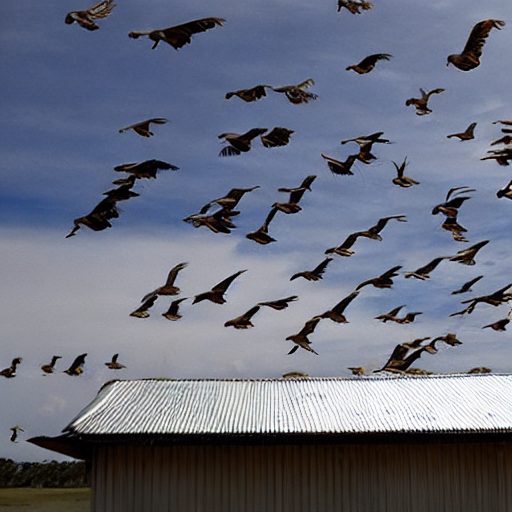

In [51]:
prompt = model_predictions[3]
image = pipe(prompt).images[0]  
print(prompt)
image

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.74it/s]


model prediction: eesbling and buzzing its computeroshing as time goes on.
original caption:  The vibrations of wings on a swarm of bees is causing a sound of buzzing.


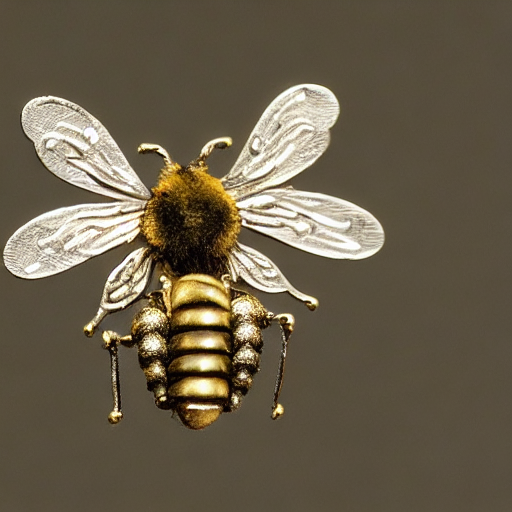

In [74]:
pos = 26
prompt = model_predictions[pos]
image = pipe(prompt).images[0]  
print('model prediction:', prompt)
print('original caption: ', test_captions[pos])
image

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.19it/s]


model prediction: ubbles ring into a toilet, then flows into a container.
original caption:  Water is poured from a container and goes down a drain.


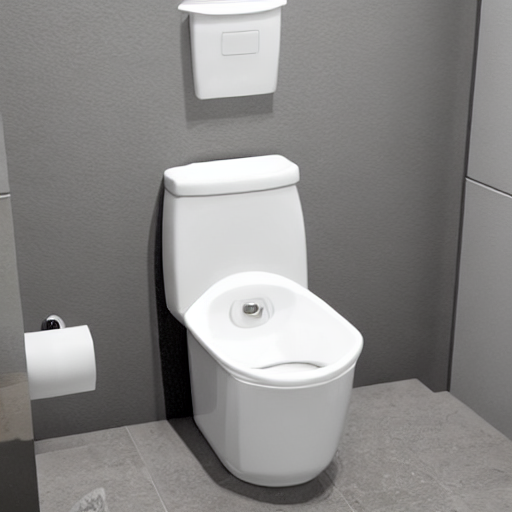

In [75]:
pos = 27
prompt = model_predictions[pos]
image = pipe(prompt).images[0]  
print('model prediction:', prompt)
print('original caption: ', test_captions[pos])
image

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.31it/s]


model prediction: ees drone rumbling as an airplane approaches from a distance.
original caption:  A plane flies overhead, moving further away as time passes.


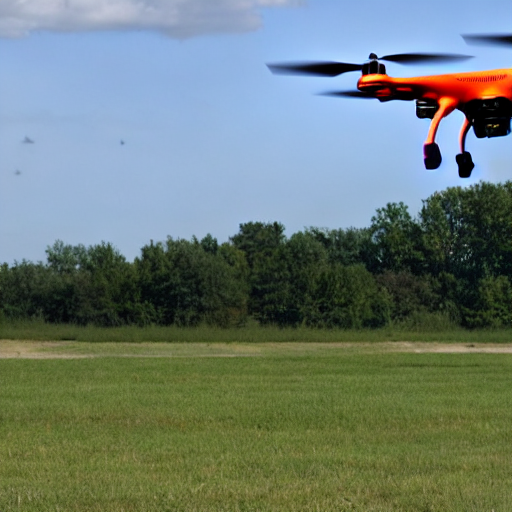

In [90]:
pos = 43
prompt = model_predictions[pos]
image = pipe(prompt).images[0]  
print('model prediction:', prompt)
print('original caption: ', test_captions[pos])
image

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.78it/s]


model prediction: alls of cars are hitting a rocky surface.
original caption:  Car Wash machinery and water jets are operating.


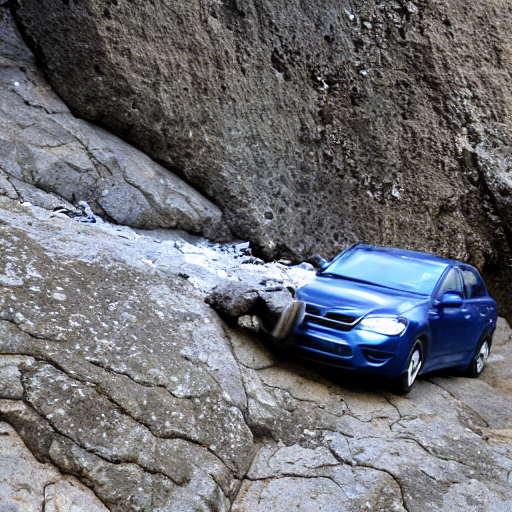

In [93]:
pos = 46
prompt = model_predictions[pos]
image = pipe(prompt).images[0]  
print('model prediction:', prompt)
print('original caption: ', test_captions[pos])
image

In [191]:
torch.save(audio_to_caption_model, 'audio_to_cap_model.pth')

In [28]:
torch.save(audio_to_caption_model, 'audio_to_cap_model50.pth')

In [ ]:
audio_to_caption_model = torch.load('audio_to_cap_model.pth')